In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras import Sequential
from keras.layers import Embedding, Conv1D, BatchNormalization, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn import metrics

from dataUtils import DataUtils
from model_utils import ModelUtils

In [2]:
dset = DataUtils.readData('cleaned_data_emission.tsv', sep='\t')

   #      Name  Epsilon      Solvent  Quantum Yield    Solvent.1  \
0  1   Benzene      210  cyclohexane          0.053       hexane   
1  2   Toluene     2860  cyclohexane          0.170  cyclohexane   
2  3  o-Xylene      254  cyclohexane          0.170       hexane   
3  4  m-Xylene      284  cyclohexane          0.130       hexane   
4  5  p-Xylene      770  cyclohexane          0.220       hexane   

                            File                         File.1  Absorption  \
0    A01_71-43-2_Benzene.abs.txt    A01_71-43-2_Benzene.ems.txt      254.75   
1   A02_108-88-3_Toluene.abs.txt   A02_108-88-3_Toluene.ems.txt      261.75   
2   A03_95-47-6_o-Xylene.abs.txt   A03_95-47-6_o-Xylene.ems.txt      263.00   
3  A04_108-38-3_m-Xylene.abs.txt  A04_108-38-3_m-Xylene.ems.txt      265.00   
4  A05_106-42-3_p-Xylene.abs.txt  A05_106-42-3_p-Xylene.ems.txt      275.00   

            SMILES  Emission  
0      C1=CC=CC=C1     287.0  
1     CC1=CC=CC=C1     289.5  
2    CC1=CC=CC=C1C     

In [3]:
data = pd.read_csv('cleaned_data_emission.tsv', sep ='\t' )

In [3]:
data['Emission'].fillna(0, inplace=True)

In [4]:
dset = data.values

In [5]:
X, y_ems = DataUtils.get_xy(dset, 9,10)

In [8]:
y_ems_fill_0=np.array(list(map(np.nan_to_num, y_ems)))

#### Drop NAs from ems

In [2]:
data = pd.read_csv('cleaned_data_emission.tsv', sep ='\t' )

In [42]:
data_rm_naems = data[data['Emission'].notna()]

In [43]:
dset = data_rm_naems.values

In [44]:
X, y_ems = DataUtils.get_xy(dset, 9,10)

In [45]:
uniform_length = DataUtils.get_max_len(X) + 5

In [46]:
uniform_length

178

In [47]:
word_map=DataUtils.load_wordmap_from_json('smiles_wordmap.json')

In [48]:
X_numeric = DataUtils.numeric_encoding(x_list=X, word_map=word_map, uniform_length=uniform_length)

In [49]:
X_train, X_test, y_train, y_test = DataUtils.splitData(x=X_numeric, y=y_ems, ratio=0.2)
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(139, 178)
(35, 178)
(139, 1)
(35, 1)


In [50]:
model = Sequential()
model.add(Embedding(len(word_map), 50, input_length=uniform_length))
model.add(BatchNormalization())
model.add(Conv1D(192,10,activation='relu'))
model.add(Dropout(0.4))
model.add(Conv1D(192,5,activation='relu'))
model.add(Conv1D(192,3,activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='linear'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 178, 50)           2100      
_________________________________________________________________
batch_normalization_2 (Batch (None, 178, 50)           200       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 169, 192)          96192     
_________________________________________________________________
dropout_3 (Dropout)          (None, 169, 192)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 165, 192)          184512    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 163, 192)          110784    
_________________________________________________________________
flatten_2 (Flatten)          (None, 31296)             0         
__________

In [51]:
optimizer = Adam(lr=0.00025)

model.compile(loss="mse", optimizer=optimizer, metrics=[ModelUtils.coeff_determination])

In [52]:
callbacks_list = [
    ModelCheckpoint(filepath="ems_dropna.best.hdf5", monitor='val_loss', save_best_only=True, verbose=1, mode='auto')    
]

In [53]:
history = model.fit(x=X_train, y=y_train, batch_size=128, epochs=250, validation_data=(X_test,y_test), callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Train on 139 samples, validate on 35 samples
Epoch 1/250
139/139 [==============================] - 2s 16ms/step - loss: 259747.1389 - coeff_determination: -12.2328 - val_loss: 239923.2812 - val_coeff_determination: -10.7189

Epoch 00001: val_loss improved from inf to 239923.28125, saving model to ems_dropna.best.hdf5
Epoch 2/250
139/139 [==============================] - 1s 9ms/step - loss: 250833.6497 - coeff_determination: -11.7145 - val_loss: 224879.5312 - val_coeff_determination: -9.9841

Epoch 00002: val_loss improved from 239923.28125 to 224879.53125, saving model to ems_dropna.best.hdf5
Epoch 3/250
139/139 [==============================] - 1s 8ms/step - loss: 233309.7610 - coeff_determination: -10.9280 - val_loss: 193326.2812 - val_coeff_determination: -8.4429

Epoch 00003: val_loss improved from 224879.53125 to 193326.28125, saving model to ems_dropna.best.hdf5
Epoch 4/250
139/139 [==============================] - 1s 8ms/step -

139/139 [==============================] - 1s 10ms/step - loss: 11252.1630 - coeff_determination: 0.4198 - val_loss: 6753.2490 - val_coeff_determination: 0.6701

Epoch 00033: val_loss did not improve from 6291.16406
Epoch 34/250
139/139 [==============================] - 1s 11ms/step - loss: 12997.3740 - coeff_determination: 0.3518 - val_loss: 6718.6992 - val_coeff_determination: 0.6718

Epoch 00034: val_loss did not improve from 6291.16406
Epoch 35/250
139/139 [==============================] - 1s 11ms/step - loss: 14099.8862 - coeff_determination: 0.2786 - val_loss: 6034.2231 - val_coeff_determination: 0.7053

Epoch 00035: val_loss improved from 6291.16406 to 6034.22314, saving model to ems_dropna.best.hdf5
Epoch 36/250
139/139 [==============================] - 1s 10ms/step - loss: 11017.8053 - coeff_determination: 0.4385 - val_loss: 7715.0493 - val_coeff_determination: 0.6232

Epoch 00036: val_loss did not improve from 6034.22314
Epoch 37/250
139/139 [==============================

139/139 [==============================] - 1s 10ms/step - loss: 8565.6043 - coeff_determination: 0.5651 - val_loss: 4831.6562 - val_coeff_determination: 0.7640

Epoch 00102: val_loss did not improve from 4760.27588
Epoch 103/250
139/139 [==============================] - 1s 11ms/step - loss: 8944.7133 - coeff_determination: 0.5343 - val_loss: 6841.8608 - val_coeff_determination: 0.6658

Epoch 00103: val_loss did not improve from 4760.27588
Epoch 104/250
139/139 [==============================] - 1s 11ms/step - loss: 8814.3920 - coeff_determination: 0.5493 - val_loss: 9944.5322 - val_coeff_determination: 0.5143

Epoch 00104: val_loss did not improve from 4760.27588
Epoch 105/250
139/139 [==============================] - 1s 11ms/step - loss: 10819.6348 - coeff_determination: 0.4489 - val_loss: 8430.9980 - val_coeff_determination: 0.5882

Epoch 00105: val_loss did not improve from 4760.27588
Epoch 106/250
139/139 [==============================] - 1s 10ms/step - loss: 9006.4556 - coeff_d

139/139 [==============================] - 1s 11ms/step - loss: 7501.2452 - coeff_determination: 0.6208 - val_loss: 5639.2261 - val_coeff_determination: 0.7246

Epoch 00138: val_loss did not improve from 4760.27588
Epoch 139/250
139/139 [==============================] - 2s 14ms/step - loss: 6145.1946 - coeff_determination: 0.6888 - val_loss: 5660.2178 - val_coeff_determination: 0.7235

Epoch 00139: val_loss did not improve from 4760.27588
Epoch 140/250
139/139 [==============================] - 2s 14ms/step - loss: 6263.5150 - coeff_determination: 0.6820 - val_loss: 5566.3223 - val_coeff_determination: 0.7281

Epoch 00140: val_loss did not improve from 4760.27588
Epoch 141/250
139/139 [==============================] - 2s 15ms/step - loss: 8178.9983 - coeff_determination: 0.5832 - val_loss: 5526.5161 - val_coeff_determination: 0.7301

Epoch 00141: val_loss did not improve from 4760.27588
Epoch 142/250
139/139 [==============================] - 2s 12ms/step - loss: 8007.5836 - coeff_de

139/139 [==============================] - 2s 11ms/step - loss: 8898.9627 - coeff_determination: 0.5488 - val_loss: 7653.9106 - val_coeff_determination: 0.6261

Epoch 00174: val_loss did not improve from 4760.27588
Epoch 175/250
139/139 [==============================] - 1s 11ms/step - loss: 6736.5216 - coeff_determination: 0.6603 - val_loss: 7515.8276 - val_coeff_determination: 0.6329

Epoch 00175: val_loss did not improve from 4760.27588
Epoch 176/250
139/139 [==============================] - 1s 11ms/step - loss: 6473.4314 - coeff_determination: 0.6759 - val_loss: 7221.5068 - val_coeff_determination: 0.6473

Epoch 00176: val_loss did not improve from 4760.27588
Epoch 177/250
139/139 [==============================] - 1s 11ms/step - loss: 7623.0096 - coeff_determination: 0.6034 - val_loss: 9057.8818 - val_coeff_determination: 0.5576

Epoch 00177: val_loss did not improve from 4760.27588
Epoch 178/250
139/139 [==============================] - 1s 11ms/step - loss: 11488.9722 - coeff_d

139/139 [==============================] - 2s 13ms/step - loss: 8709.4996 - coeff_determination: 0.5538 - val_loss: 7276.2266 - val_coeff_determination: 0.6446

Epoch 00210: val_loss did not improve from 4760.27588
Epoch 211/250
139/139 [==============================] - 1s 11ms/step - loss: 5770.7516 - coeff_determination: 0.7033 - val_loss: 7070.3110 - val_coeff_determination: 0.6547

Epoch 00211: val_loss did not improve from 4760.27588
Epoch 212/250
139/139 [==============================] - 1s 11ms/step - loss: 6773.7824 - coeff_determination: 0.6512 - val_loss: 6703.5474 - val_coeff_determination: 0.6726

Epoch 00212: val_loss did not improve from 4760.27588
Epoch 213/250
139/139 [==============================] - 1s 11ms/step - loss: 6838.5537 - coeff_determination: 0.6422 - val_loss: 7870.0498 - val_coeff_determination: 0.6156

Epoch 00213: val_loss did not improve from 4760.27588
Epoch 214/250
139/139 [==============================] - 1s 11ms/step - loss: 7337.9673 - coeff_de

139/139 [==============================] - 1s 11ms/step - loss: 6468.8879 - coeff_determination: 0.6715 - val_loss: 7370.9600 - val_coeff_determination: 0.6400

Epoch 00246: val_loss did not improve from 4760.27588
Epoch 247/250
139/139 [==============================] - 2s 12ms/step - loss: 6078.6806 - coeff_determination: 0.6901 - val_loss: 6854.5361 - val_coeff_determination: 0.6652

Epoch 00247: val_loss did not improve from 4760.27588
Epoch 248/250
139/139 [==============================] - 1s 11ms/step - loss: 5829.8789 - coeff_determination: 0.7039 - val_loss: 6711.0684 - val_coeff_determination: 0.6722

Epoch 00248: val_loss did not improve from 4760.27588
Epoch 249/250
139/139 [==============================] - 1s 11ms/step - loss: 5924.0438 - coeff_determination: 0.6995 - val_loss: 6609.0757 - val_coeff_determination: 0.6772

Epoch 00249: val_loss did not improve from 4760.27588
Epoch 250/250
139/139 [==============================] - 2s 15ms/step - loss: 4949.4513 - coeff_de

C:\Users\Yang\.conda\envs\test_speedcom\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


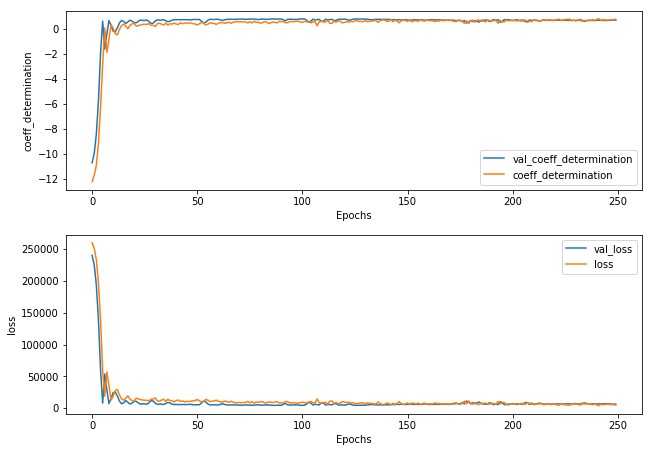

In [54]:
hist = history.history

plt.figure(figsize=(10, 8))

for label in ['val_coeff_determination','coeff_determination']:
    plt.subplot(211)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("coeff_determination")
    
for label in ['val_loss','loss']:
    plt.subplot(212)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("loss")
    
plt.subplots_adjust(top=0.8, bottom=0.1, left=0.10, right=0.9, hspace=0.25,
                    wspace=0.35)

In [62]:
model_json = model.to_json()
with open("model_smiles_ems_dropna.json", "w") as json_file:
    json_file.write(model_json)

print("Saved model to disk")

Saved model to disk


In [65]:
from keras.models import model_from_json

In [66]:
json_file = open('model_smiles_ems_dropna.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [67]:
loaded_model.load_weights('ems_dropna.best.hdf5')

In [68]:
metrics.r2_score(y_train, loaded_model.predict(X_train))

0.7745232320404232

In [69]:
metrics.r2_score(y_test, loaded_model.predict(X_test))

0.7674868364135867

In [70]:
metrics.mean_absolute_error(y_train, loaded_model.predict(X_train))

50.18008839998314

In [71]:
metrics.mean_absolute_error(y_test, loaded_model.predict(X_test))

54.34515729631696

In [72]:
def plot_model_error(x_train, x_test, y_train, y_test, model, save_fig_fname=None):
        """
        input model and actual data, plot train, test predicted data and error
        """
        y_train = y_train.reshape(-1,1)
        y_test = y_test.reshape(-1,1)
    
        plt.figure(figsize=(8, 10), dpi=100)
        plt.subplot(211)
        plt.scatter(y_train, model.predict(X_train), color = 'r', label = 'train')
        plt.scatter(y_test, model.predict(X_test), color = 'blue', label = 'test')
        plt.xlabel('Actual Absorption Wavelength(nm)', fontsize=12)
        plt.ylabel('Predicted Absorption Wavelength(nm)', fontsize=12)
        plt.legend(loc='upper center')

        plt.subplot(212)
        plt.scatter(y_train, model.predict(X_train)-y_train, color = 'r', label = 'train', marker= 'x')
        plt.scatter(y_test, model.predict(X_test)-y_test, color = 'blue', label = 'test', marker = 'x')
        plt.axhline(0, ls='--')
        plt.xlabel('Actual Absorption Wavelength(nm)', fontsize=12)
        plt.ylabel('Prediction error(nm)', fontsize=12)
        plt.legend(loc='upper center')
        
        if save_fig_fname is not None:
            plt.savefig(save_fig_fname)
        else:
            plt.show()

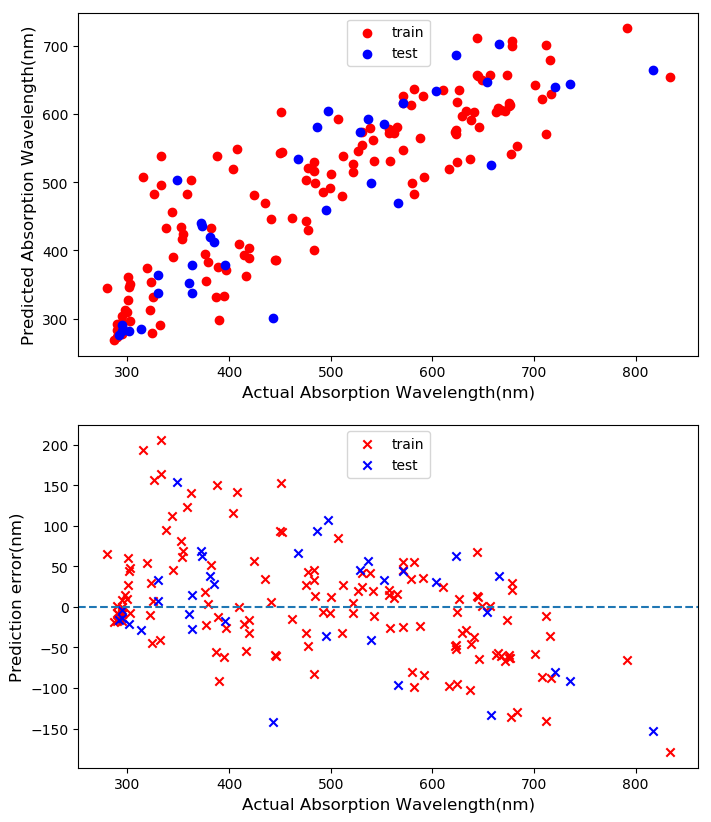

In [73]:
plot_model_error(X_train, X_test, y_train, y_test, loaded_model, save_fig_fname = None)

#### epsilon

In [134]:
dset = DataUtils.readData('cleaned_data_emission.tsv', sep='\t')


   #      Name  Epsilon      Solvent  Quantum Yield    Solvent.1  \
0  1   Benzene      210  cyclohexane          0.053       hexane   
1  2   Toluene     2860  cyclohexane          0.170  cyclohexane   
2  3  o-Xylene      254  cyclohexane          0.170       hexane   
3  4  m-Xylene      284  cyclohexane          0.130       hexane   
4  5  p-Xylene      770  cyclohexane          0.220       hexane   

                            File                         File.1  Absorption  \
0    A01_71-43-2_Benzene.abs.txt    A01_71-43-2_Benzene.ems.txt      254.75   
1   A02_108-88-3_Toluene.abs.txt   A02_108-88-3_Toluene.ems.txt      261.75   
2   A03_95-47-6_o-Xylene.abs.txt   A03_95-47-6_o-Xylene.ems.txt      263.00   
3  A04_108-38-3_m-Xylene.abs.txt  A04_108-38-3_m-Xylene.ems.txt      265.00   
4  A05_106-42-3_p-Xylene.abs.txt  A05_106-42-3_p-Xylene.ems.txt      275.00   

            SMILES  Emission  
0      C1=CC=CC=C1     287.0  
1     CC1=CC=CC=C1     289.5  
2    CC1=CC=CC=C1C     

In [135]:
X, y = DataUtils.get_xy(dset, 9, 2)

In [136]:
uniform_length = DataUtils.get_max_len(X) + 5

In [137]:
word_map=DataUtils.load_wordmap_from_json('smiles_wordmap.json')

In [82]:
X_numeric = DataUtils.numeric_encoding(x_list=X, word_map=word_map, uniform_length=uniform_length)

In [218]:
X_train, X_test, y_train, y_test = DataUtils.splitData(x=X_numeric, y=y, ratio=0.2)
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(232, 279)
(59, 279)
(232, 1)
(59, 1)


In [222]:
model = Sequential()
model.add(Embedding(len(word_map), 50, input_length=uniform_length))
model.add(BatchNormalization())
model.add(Conv1D(192,10,activation='relu'))
model.add(Dropout(0.4))
model.add(Conv1D(192,5,activation='relu'))
model.add(Conv1D(192,3,activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='linear'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 279, 50)           2100      
_________________________________________________________________
batch_normalization_16 (Batc (None, 279, 50)           200       
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 270, 192)          96192     
_________________________________________________________________
dropout_31 (Dropout)         (None, 270, 192)          0         
_________________________________________________________________
conv1d_29 (Conv1D)           (None, 266, 192)          184512    
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 264, 192)          110784    
_________________________________________________________________
flatten_15 (Flatten)         (None, 50688)             0         
__________

In [223]:
optimizer = Adam(lr=0.1)
model.compile(loss="mse", optimizer=optimizer, metrics=[ModelUtils.coeff_determination, lr_metric])
callbacks_list = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=20, min_lr=1e-9, verbose=1, mode='auto',cooldown=0),
    ModelCheckpoint(filepath="epsilon.best_cnn.hdf5", monitor='val_loss', save_best_only=True, verbose=1, mode='auto')    
]

In [224]:
history = model.fit(x=X_train, y=y_train, batch_size=128, epochs=250, validation_data=(X_test,y_test), callbacks=callbacks_list)

Train on 232 samples, validate on 59 samples
Epoch 1/250
232/232 [==============================] - 8s 34ms/step - loss: 1009182914061256448.0000 - coeff_determination: -110130097.3409 - lr: 0.0500 - val_loss: 28722214207488.0000 - val_coeff_determination: -3853.8596 - val_lr: 0.0500

Epoch 00001: val_loss improved from inf to 28722214207488.00000, saving model to epsilon.best_cnn.hdf5
Epoch 2/250
232/232 [==============================] - 4s 17ms/step - loss: 15122796405018.4824 - coeff_determination: -2213.5527 - lr: 0.0500 - val_loss: 1084475244544.0000 - val_coeff_determination: -144.5494 - val_lr: 0.0500

Epoch 00002: val_loss improved from 28722214207488.00000 to 1084475244544.00000, saving model to epsilon.best_cnn.hdf5
Epoch 3/250
232/232 [==============================] - 4s 18ms/step - loss: 71988681057.1034 - coeff_determination: -9.1526 - lr: 0.0500 - val_loss: 388028235776.0000 - val_coeff_determination: -51.0780 - val_lr: 0.0500

Epoch 00003: val_loss improved from 108447

Epoch 26/250
232/232 [==============================] - 5s 21ms/step - loss: 11414230475.0345 - coeff_determination: -0.4518 - lr: 0.0500 - val_loss: 12531978240.0000 - val_coeff_determination: -0.6819 - val_lr: 0.0500

Epoch 00026: val_loss improved from 12532000768.00000 to 12531978240.00000, saving model to epsilon.best_cnn.hdf5
Epoch 27/250


KeyboardInterrupt: 

In [87]:
model_json = model.to_json()
with open("model_smiles_epsilon.json", "w") as json_file:
    json_file.write(model_json)

print("Saved model to disk")

Saved model to disk


In [88]:
json_file = open('model_smiles_epsilon.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('epsilon.best.hdf5')

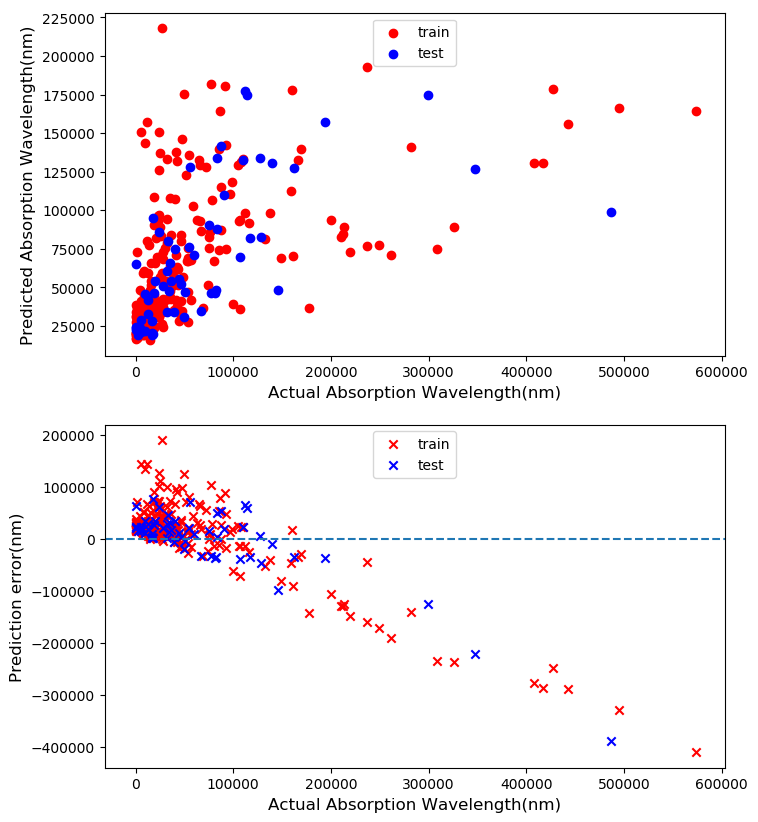

In [89]:
plot_model_error(X_train, X_test, y_train, y_test, loaded_model, save_fig_fname = None)

### Data transformation

In [138]:
from numpy.random import seed
from numpy.random import randn
from numpy import exp
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# seed the random number generator
seed(123)

In [139]:
dset = DataUtils.readData('cleaned_data_emission.tsv', sep='\t')

X, y = DataUtils.get_xy(dset, 9, 2)
uniform_length = DataUtils.get_max_len(X) + 5
word_map=DataUtils.load_wordmap_from_json('smiles_wordmap.json')
X_numeric = DataUtils.numeric_encoding(x_list=X, word_map=word_map, uniform_length=uniform_length)

   #      Name  Epsilon      Solvent  Quantum Yield    Solvent.1  \
0  1   Benzene      210  cyclohexane          0.053       hexane   
1  2   Toluene     2860  cyclohexane          0.170  cyclohexane   
2  3  o-Xylene      254  cyclohexane          0.170       hexane   
3  4  m-Xylene      284  cyclohexane          0.130       hexane   
4  5  p-Xylene      770  cyclohexane          0.220       hexane   

                            File                         File.1  Absorption  \
0    A01_71-43-2_Benzene.abs.txt    A01_71-43-2_Benzene.ems.txt      254.75   
1   A02_108-88-3_Toluene.abs.txt   A02_108-88-3_Toluene.ems.txt      261.75   
2   A03_95-47-6_o-Xylene.abs.txt   A03_95-47-6_o-Xylene.ems.txt      263.00   
3  A04_108-38-3_m-Xylene.abs.txt  A04_108-38-3_m-Xylene.ems.txt      265.00   
4  A05_106-42-3_p-Xylene.abs.txt  A05_106-42-3_p-Xylene.ems.txt      275.00   

            SMILES  Emission  
0      C1=CC=CC=C1     287.0  
1     CC1=CC=CC=C1     289.5  
2    CC1=CC=CC=C1C     

In [140]:
y.astype(int)

array([   210,   2860,    254,    284,    770,    190,    214,    629,
          214,   2340,   7800,  13100,  13200,   8270,  12800,   1760,
        14900,    490,    280,  13200,   8140,  14700,  17600,  28200,
         5000,   9520,   9770,  19000,  23200,  12500,  17000,   6920,
         1910,  13200,  28000,  19400,  15200,   7110,   3400,    684,
           96,  16000,  33800,  41000,  62500,  60000,  67500,  41800,
        34800,  35700,  47000,  18600,   9800,   8590,   6000,   9700,
        10000,   7200,  69200,  81700, 146000,  14000,  87000, 127000,
        26300,  53700,  50100,  25100,  37200,  23100,  27600,  10200,
        28200,  27800,  33000,  82400,  27000,  55000,  43500, 139500,
         1800,  14300,   7500,  13300,  12300,    890,  44100,  11200,
        12600,  27000,  31900,   1330,  18700,   5620,  10200,  15000,
        15600,  58500,  36000,  87000,   8130,  19700,  46500,  22700,
        25600,   5700,      9,    195,   1405,   5700,   5579,  13000,
      

(array([206.,  47.,  15.,   7.,   5.,   3.,   1.,   4.,   2.,   1.]),
 array([9.000000e+00, 5.740810e+04, 1.148072e+05, 1.722063e+05,
        2.296054e+05, 2.870045e+05, 3.444036e+05, 4.018027e+05,
        4.592018e+05, 5.166009e+05, 5.740000e+05]),
 <a list of 10 Patch objects>)

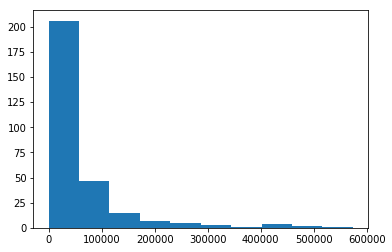

In [141]:
plt.hist(y.tolist())

In [142]:
y_trans, b_lambda=boxcox(y.astype(int), None)

In [143]:
y_trans

array([ 9.45732758, 19.20109211, 10.01093216, 10.34558697, 13.68451615,
        9.17425426,  9.51132049, 12.95360504,  9.51132049, 18.26275248,
       24.48914098, 27.65833319, 27.70725707, 24.83084943, 27.50973815,
       16.99273858, 28.49656312, 12.09028724, 10.30265897, 27.70725707,
       24.73792927, 28.40758274, 29.61271938, 32.97744181, 22.0164947 ,
       25.66915949, 25.8260791 , 30.1380664 , 31.54658374, 27.35831709,
       29.3772349 , 23.80214421, 17.35017858, 27.70725707, 32.92429245,
       30.28243682, 28.62825051, 23.95618192, 20.04001715, 13.25301553,
        7.3848549 , 28.96947719, 34.35538266, 35.87936724, 39.41416853,
       39.05897065, 40.09160729, 36.03507295, 34.58179304, 34.78113442,
       36.99259589, 29.99123211, 25.84469187, 25.05467252, 23.00425122,
       25.78247001, 25.96762012, 24.02799497, 40.31274788, 41.81706351,
       47.47906609, 28.08828363, 42.39938838, 46.05990356, 32.45975216,
       38.10799185, 37.52355938, 32.11708841, 35.10457065, 31.51

(array([ 2., 14.,  9., 35., 86., 62., 47., 18., 11.,  7.]),
 array([ 2.74714835,  8.84103894, 14.93492954, 21.02882014, 27.12271073,
        33.21660133, 39.31049192, 45.40438252, 51.49827312, 57.59216371,
        63.68605431]),
 <a list of 10 Patch objects>)

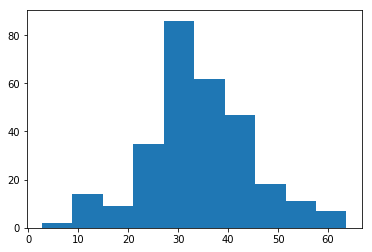

In [131]:
plt.hist(y_trans.tolist())

In [228]:
X_train, X_test, y_train, y_test = DataUtils.splitData(x=X_numeric, y=y_trans, ratio=0.2)
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(232, 279)
(59, 279)
(232, 1)
(59, 1)


In [226]:
model = Sequential()
model.add(Embedding(len(word_map), 50, input_length=uniform_length))
model.add(BatchNormalization())
model.add(Conv1D(192,10,activation='relu'))
model.add(Dropout(0.4))
model.add(Conv1D(192,5,activation='relu'))
model.add(Dropout(0.4))
model.add(Conv1D(192,3,activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='linear'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 279, 50)           2100      
_________________________________________________________________
batch_normalization_17 (Batc (None, 279, 50)           200       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 270, 192)          96192     
_________________________________________________________________
dropout_33 (Dropout)         (None, 270, 192)          0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 266, 192)          184512    
_________________________________________________________________
dropout_34 (Dropout)         (None, 266, 192)          0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 264, 192)          110784    
__________

In [227]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

In [216]:
optimizer = Adam(lr=0.05)
lr_metric = get_lr_metric(optimizer)
model.compile(loss="mse", optimizer=optimizer, metrics=[ModelUtils.coeff_determination, lr_metric])
callbacks_list = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=20, min_lr=1e-12, verbose=1, mode='auto',cooldown=0),
    ModelCheckpoint(filepath="epsilon.best_cnn.hdf5", monitor='val_loss', save_best_only=True, verbose=1, mode='auto')    
]

In [217]:
history = model.fit(x=X_train, y=y_train, batch_size=128, epochs=250, validation_data=(X_test,y_test), callbacks=callbacks_list)

Train on 232 samples, validate on 59 samples
Epoch 1/250
232/232 [==============================] - 8s 33ms/step - loss: 2500430379434062.5000 - coeff_determination: -20378666555468.3320 - lr: 0.0500 - val_loss: 112496304128.0000 - val_coeff_determination: -949013568.0000 - val_lr: 0.0500

Epoch 00001: val_loss improved from inf to 112496304128.00000, saving model to epsilon.best_cnn.hdf5
Epoch 2/250
232/232 [==============================] - 3s 15ms/step - loss: 91342860419.1825 - coeff_determination: -822403388.8395 - lr: 0.0500 - val_loss: 493.7593 - val_coeff_determination: -3.1653 - val_lr: 0.0500

Epoch 00002: val_loss improved from 112496304128.00000 to 493.75931, saving model to epsilon.best_cnn.hdf5
Epoch 3/250
232/232 [==============================] - 4s 16ms/step - loss: 583.1427 - coeff_determination: -4.1802 - lr: 0.0500 - val_loss: 1165.3688 - val_coeff_determination: -8.8310 - val_lr: 0.0500

Epoch 00003: val_loss did not improve from 493.75931
Epoch 4/250
232/232 [====

KeyboardInterrupt: 

#### Use LSTM model of transformed data

In [233]:
from keras.layers import LSTM, Dense, Embedding, Dropout, Flatten, BatchNormalization
# sequence data packages
from keras.preprocessing import sequence

In [257]:
hidden_size = 50
model = Sequential()
model.add(Embedding(len(word_map), hidden_size, input_length=uniform_length))
model.add(BatchNormalization())
model.add(LSTM(hidden_size, return_sequences=True))

model.add(LSTM(hidden_size, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(Dropout(0.4))
model.add(Dense(hidden_size, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 279, 50)           2100      
_________________________________________________________________
batch_normalization_21 (Batc (None, 279, 50)           200       
_________________________________________________________________
lstm_25 (LSTM)               (None, 279, 50)           20200     
_________________________________________________________________
lstm_26 (LSTM)               (None, 279, 50)           20200     
_________________________________________________________________
dropout_45 (Dropout)         (None, 279, 50)           0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 279, 50)           20200     
_________________________________________________________________
dropout_46 (Dropout)         (None, 279, 50)           0         
__________

In [258]:
optimizer = Adam(lr=0.00025)
lr_metric = get_lr_metric(optimizer)
model.compile(loss="mse", optimizer=optimizer, metrics=[ModelUtils.coeff_determination, lr_metric])
callbacks_list = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=15, min_lr=1e-9, verbose=1, mode='auto',cooldown=0),
    ModelCheckpoint(filepath="epsilon.best_-1.hdf5", monitor='val_loss', save_best_only=True, verbose=1, mode='auto')    
]

In [259]:
history = model.fit(x=X_train, y=y_train, batch_size=128, epochs=250, validation_data=(X_test,y_test), callbacks=callbacks_list)

Train on 232 samples, validate on 59 samples
Epoch 1/250
232/232 [==============================] - 13s 54ms/step - loss: 1241.4215 - coeff_determination: -10.0529 - lr: 2.5000e-04 - val_loss: 1385.5630 - val_coeff_determination: -10.6885 - val_lr: 2.5000e-04

Epoch 00001: val_loss improved from inf to 1385.56299, saving model to epsilon.best_-1.hdf5
Epoch 2/250
232/232 [==============================] - 4s 17ms/step - loss: 1228.8844 - coeff_determination: -9.8923 - lr: 2.5000e-04 - val_loss: 1368.9729 - val_coeff_determination: -10.5486 - val_lr: 2.5000e-04

Epoch 00002: val_loss improved from 1385.56299 to 1368.97290, saving model to epsilon.best_-1.hdf5
Epoch 3/250
232/232 [==============================] - 4s 17ms/step - loss: 1209.5522 - coeff_determination: -10.2930 - lr: 2.5000e-04 - val_loss: 1344.8713 - val_coeff_determination: -10.3453 - val_lr: 2.5000e-04

Epoch 00003: val_loss improved from 1368.97290 to 1344.87134, saving model to epsilon.best_-1.hdf5
Epoch 4/250
232/232 

232/232 [==============================] - 5s 22ms/step - loss: 86.5136 - coeff_determination: 0.2221 - lr: 2.5000e-04 - val_loss: 106.8643 - val_coeff_determination: 0.0985 - val_lr: 2.5000e-04

Epoch 00028: val_loss did not improve from 102.42229
Epoch 29/250
232/232 [==============================] - 5s 22ms/step - loss: 84.2293 - coeff_determination: 0.2495 - lr: 2.5000e-04 - val_loss: 101.9711 - val_coeff_determination: 0.1398 - val_lr: 2.5000e-04

Epoch 00029: val_loss improved from 102.42229 to 101.97110, saving model to epsilon.best_-1.hdf5
Epoch 30/250
232/232 [==============================] - 5s 21ms/step - loss: 81.6290 - coeff_determination: 0.2620 - lr: 2.5000e-04 - val_loss: 95.2238 - val_coeff_determination: 0.1967 - val_lr: 2.5000e-04

Epoch 00030: val_loss improved from 101.97110 to 95.22382, saving model to epsilon.best_-1.hdf5
Epoch 31/250
232/232 [==============================] - 5s 22ms/step - loss: 78.7175 - coeff_determination: 0.2990 - lr: 2.5000e-04 - val_los


Epoch 00057: val_loss did not improve from 66.78232
Epoch 58/250
232/232 [==============================] - 5s 23ms/step - loss: 66.2379 - coeff_determination: 0.4047 - lr: 1.8750e-04 - val_loss: 67.9445 - val_coeff_determination: 0.4268 - val_lr: 1.8750e-04

Epoch 00058: val_loss did not improve from 66.78232
Epoch 59/250
232/232 [==============================] - 5s 22ms/step - loss: 65.0927 - coeff_determination: 0.4233 - lr: 1.8750e-04 - val_loss: 68.0061 - val_coeff_determination: 0.4263 - val_lr: 1.8750e-04

Epoch 00059: val_loss did not improve from 66.78232
Epoch 60/250
232/232 [==============================] - 6s 24ms/step - loss: 65.4186 - coeff_determination: 0.4234 - lr: 1.8750e-04 - val_loss: 68.1374 - val_coeff_determination: 0.4252 - val_lr: 1.8750e-04

Epoch 00060: val_loss did not improve from 66.78232
Epoch 61/250
232/232 [==============================] - 6s 25ms/step - loss: 65.2750 - coeff_determination: 0.4111 - lr: 1.8750e-04 - val_loss: 68.2379 - val_coeff_det

232/232 [==============================] - 4s 18ms/step - loss: 59.8010 - coeff_determination: 0.4705 - lr: 1.8750e-04 - val_loss: 62.4663 - val_coeff_determination: 0.4730 - val_lr: 1.8750e-04

Epoch 00087: val_loss improved from 62.83666 to 62.46626, saving model to epsilon.best_-1.hdf5
Epoch 88/250
232/232 [==============================] - 4s 19ms/step - loss: 59.1956 - coeff_determination: 0.4742 - lr: 1.8750e-04 - val_loss: 62.2236 - val_coeff_determination: 0.4751 - val_lr: 1.8750e-04

Epoch 00088: val_loss improved from 62.46626 to 62.22360, saving model to epsilon.best_-1.hdf5
Epoch 89/250
232/232 [==============================] - 5s 22ms/step - loss: 58.7205 - coeff_determination: 0.4781 - lr: 1.8750e-04 - val_loss: 62.1025 - val_coeff_determination: 0.4761 - val_lr: 1.8750e-04

Epoch 00089: val_loss improved from 62.22360 to 62.10245, saving model to epsilon.best_-1.hdf5
Epoch 90/250
232/232 [==============================] - 4s 19ms/step - loss: 58.6462 - coeff_determinati


Epoch 00114: val_loss did not improve from 54.87580
Epoch 115/250
232/232 [==============================] - 5s 21ms/step - loss: 49.6693 - coeff_determination: 0.5602 - lr: 1.8750e-04 - val_loss: 54.6068 - val_coeff_determination: 0.5393 - val_lr: 1.8750e-04

Epoch 00115: val_loss improved from 54.87580 to 54.60685, saving model to epsilon.best_-1.hdf5
Epoch 116/250
232/232 [==============================] - 5s 21ms/step - loss: 49.7089 - coeff_determination: 0.5614 - lr: 1.8750e-04 - val_loss: 55.3627 - val_coeff_determination: 0.5330 - val_lr: 1.8750e-04

Epoch 00116: val_loss did not improve from 54.60685
Epoch 117/250
232/232 [==============================] - 5s 22ms/step - loss: 48.9633 - coeff_determination: 0.5666 - lr: 1.8750e-04 - val_loss: 56.1380 - val_coeff_determination: 0.5264 - val_lr: 1.8750e-04

Epoch 00117: val_loss did not improve from 54.60685
Epoch 118/250
232/232 [==============================] - 5s 22ms/step - loss: 48.5446 - coeff_determination: 0.5691 - lr:

232/232 [==============================] - 5s 23ms/step - loss: 40.9523 - coeff_determination: 0.6384 - lr: 1.4062e-04 - val_loss: 55.9582 - val_coeff_determination: 0.5279 - val_lr: 1.4062e-04

Epoch 00145: val_loss did not improve from 53.44455
Epoch 146/250
232/232 [==============================] - 4s 19ms/step - loss: 42.5354 - coeff_determination: 0.6166 - lr: 1.4062e-04 - val_loss: 57.4640 - val_coeff_determination: 0.5152 - val_lr: 1.4062e-04

Epoch 00146: val_loss did not improve from 53.44455
Epoch 147/250
232/232 [==============================] - 5s 23ms/step - loss: 40.6673 - coeff_determination: 0.6390 - lr: 1.4062e-04 - val_loss: 56.3098 - val_coeff_determination: 0.5250 - val_lr: 1.4062e-04

Epoch 00147: val_loss did not improve from 53.44455
Epoch 148/250
232/232 [==============================] - 4s 19ms/step - loss: 40.5599 - coeff_determination: 0.6398 - lr: 1.4062e-04 - val_loss: 55.8450 - val_coeff_determination: 0.5289 - val_lr: 1.4062e-04

Epoch 00148: val_loss 

232/232 [==============================] - 5s 22ms/step - loss: 37.5637 - coeff_determination: 0.6626 - lr: 7.9102e-05 - val_loss: 56.2928 - val_coeff_determination: 0.5251 - val_lr: 7.9102e-05

Epoch 00176: val_loss did not improve from 53.44455
Epoch 177/250
232/232 [==============================] - 5s 20ms/step - loss: 37.5789 - coeff_determination: 0.6652 - lr: 7.9102e-05 - val_loss: 56.2659 - val_coeff_determination: 0.5253 - val_lr: 7.9102e-05

Epoch 00177: val_loss did not improve from 53.44455
Epoch 178/250
232/232 [==============================] - 5s 19ms/step - loss: 36.7793 - coeff_determination: 0.6564 - lr: 7.9102e-05 - val_loss: 56.3289 - val_coeff_determination: 0.5248 - val_lr: 7.9102e-05

Epoch 00178: val_loss did not improve from 53.44455
Epoch 179/250
232/232 [==============================] - 5s 21ms/step - loss: 37.6540 - coeff_determination: 0.6597 - lr: 7.9102e-05 - val_loss: 56.0331 - val_coeff_determination: 0.5273 - val_lr: 7.9102e-05

Epoch 00179: val_loss 

232/232 [==============================] - 4s 19ms/step - loss: 35.7226 - coeff_determination: 0.6854 - lr: 4.4495e-05 - val_loss: 56.0236 - val_coeff_determination: 0.5274 - val_lr: 4.4495e-05

Epoch 00207: val_loss did not improve from 53.44455
Epoch 208/250
232/232 [==============================] - 4s 19ms/step - loss: 35.7761 - coeff_determination: 0.6825 - lr: 4.4495e-05 - val_loss: 56.0581 - val_coeff_determination: 0.5271 - val_lr: 4.4495e-05

Epoch 00208: val_loss did not improve from 53.44455
Epoch 209/250
232/232 [==============================] - 4s 19ms/step - loss: 35.2009 - coeff_determination: 0.6863 - lr: 4.4495e-05 - val_loss: 55.7074 - val_coeff_determination: 0.5301 - val_lr: 4.4495e-05

Epoch 00209: val_loss did not improve from 53.44455
Epoch 210/250
232/232 [==============================] - 5s 20ms/step - loss: 35.5221 - coeff_determination: 0.6855 - lr: 4.4495e-05 - val_loss: 55.4963 - val_coeff_determination: 0.5318 - val_lr: 4.4495e-05

Epoch 00210: val_loss 

232/232 [==============================] - 4s 19ms/step - loss: 34.4018 - coeff_determination: 0.6949 - lr: 2.5028e-05 - val_loss: 55.1556 - val_coeff_determination: 0.5347 - val_lr: 2.5028e-05

Epoch 00238: val_loss did not improve from 53.44455
Epoch 239/250
232/232 [==============================] - 4s 19ms/step - loss: 33.4722 - coeff_determination: 0.6955 - lr: 2.5028e-05 - val_loss: 55.1027 - val_coeff_determination: 0.5352 - val_lr: 2.5028e-05

Epoch 00239: val_loss did not improve from 53.44455
Epoch 240/250
232/232 [==============================] - 4s 19ms/step - loss: 34.6855 - coeff_determination: 0.6924 - lr: 2.5028e-05 - val_loss: 55.1278 - val_coeff_determination: 0.5349 - val_lr: 2.5028e-05

Epoch 00240: val_loss did not improve from 53.44455
Epoch 241/250
232/232 [==============================] - 5s 20ms/step - loss: 33.8481 - coeff_determination: 0.6866 - lr: 2.5028e-05 - val_loss: 55.2502 - val_coeff_determination: 0.5339 - val_lr: 2.5028e-05

Epoch 00241: val_loss 

In [260]:
model_json = model.to_json()
with open("model_smiles_epsilon_lstmlast.json", "w") as json_file:
    json_file.write(model_json)

print("Saved model to disk")

Saved model to disk


In [265]:
json_file = open('model_smiles_epsilon_lstm.json', 'r') #'model_smiles_epsilon_lstm.json' or 'model_smiles_epsilon_lstm.json'
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('epsilon.best_-1.hdf5') #'epsilon.best2.hdf5' or 'epsilon.best_-1.hdf5'

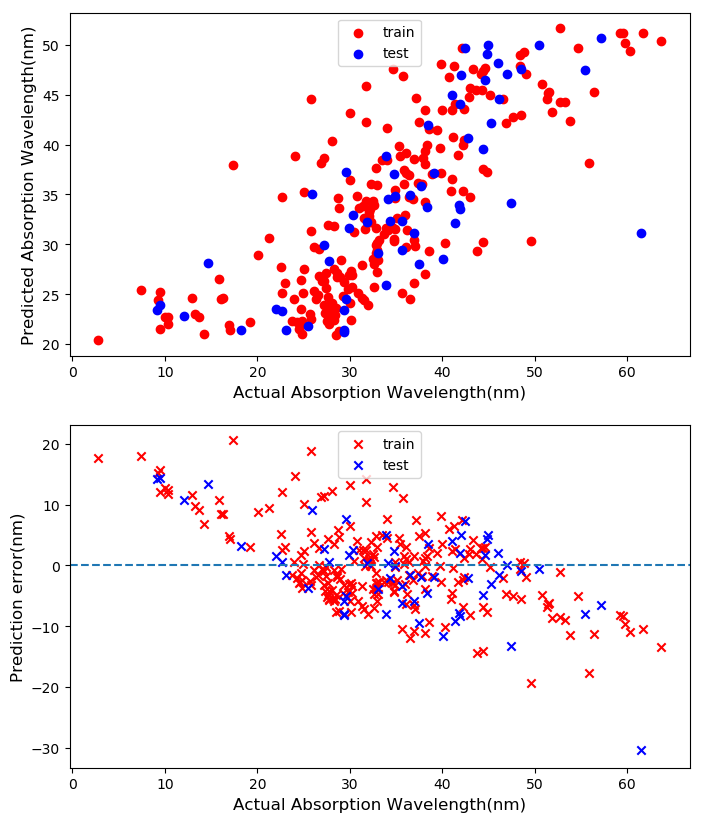

In [266]:
plot_model_error(X_train, X_test, y_train, y_test, loaded_model, save_fig_fname = None)




In [267]:
metrics.r2_score(y_train, loaded_model.predict(X_train))

0.5926248864788473

In [268]:
metrics.r2_score(y_test, loaded_model.predict(X_test))

0.5491442318636102

In [269]:
metrics.r2_score(inv_boxcox(y_train, b_lambda), inv_boxcox(loaded_model.predict(X_train), b_lambda))

0.5134712490413498

In [270]:
metrics.r2_score(inv_boxcox(y_test, b_lambda), inv_boxcox(loaded_model.predict(X_test), b_lambda))

0.26975639292158105

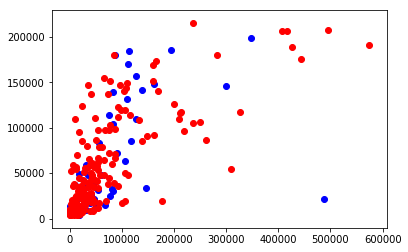

In [271]:
plt.scatter(inv_boxcox(y_test,b_lambda),inv_boxcox(loaded_model.predict(X_test), b_lambda), color = 'blue')
plt.scatter(inv_boxcox(y_train,b_lambda),inv_boxcox(loaded_model.predict(X_train), b_lambda), color = 'red')

#### demo how to predict epsiplon

In [272]:
def predict_epsilon(smiles_string = 'C1=CC=CC=C1', uniform_length_of_model = 279, word_map = None, model = None, boxcox_lambda = 1):
    indivisual_X_code = DataUtils.numeric_encoding(np.array([smiles_string]), uniform_length_of_model,word_map)
    pred_abs_wl = inv_boxcox(model.predict(indivisual_X_code), boxcox_lambda)
    return pred_abs_wl

In [273]:
predict_epsilon(word_map=word_map, model = loaded_model, boxcox_lambda=b_lambda)

array([[4526.183]], dtype=float32)

### USE non transformed data LSTM (bad!)

In [192]:
X, y = DataUtils.get_xy(dset, 9, 2)

In [201]:
X_train, X_test, y_train, y_test = DataUtils.splitData(x=X_numeric, y=y, ratio=0.2)
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(232, 279)
(59, 279)
(232, 1)
(59, 1)


In [202]:
from keras.layers import LSTM, Dense, Embedding, Dropout, Flatten, BatchNormalization
# sequence data packages
from keras.preprocessing import sequence

In [210]:
hidden_size = 50
model = Sequential()
model.add(Embedding(len(word_map), hidden_size, input_length=uniform_length))
model.add(BatchNormalization())
model.add(LSTM(hidden_size, return_sequences=True))

model.add(LSTM(hidden_size, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(Dropout(0.4))
model.add(Dense(hidden_size, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 279, 50)           2100      
_________________________________________________________________
batch_normalization_13 (Batc (None, 279, 50)           200       
_________________________________________________________________
lstm_13 (LSTM)               (None, 279, 50)           20200     
_________________________________________________________________
lstm_14 (LSTM)               (None, 279, 50)           20200     
_________________________________________________________________
dropout_24 (Dropout)         (None, 279, 50)           0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 279, 50)           20200     
_________________________________________________________________
dropout_25 (Dropout)         (None, 279, 50)           0         
__________

In [211]:
optimizer = Adam(lr=0.1)
lr_metric = get_lr_metric(optimizer)
model.compile(loss="mse", optimizer=optimizer, metrics=[ModelUtils.coeff_determination, lr_metric])
callbacks_list = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=1e-9, verbose=1, mode='auto',cooldown=0),
    ModelCheckpoint(filepath="epsilon.best_no_transform.hdf5", monitor='val_loss', save_best_only=True, verbose=1, mode='auto')    
]

In [212]:
history = model.fit(x=X_train, y=y_train, batch_size=128, epochs=250, validation_data=(X_test,y_test), callbacks=callbacks_list)

Train on 232 samples, validate on 59 samples
Epoch 1/250
232/232 [==============================] - 8s 33ms/step - loss: 11337038918.6207 - coeff_determination: -0.4429 - lr: 0.1000 - val_loss: 11873785856.0000 - val_coeff_determination: -0.5936 - val_lr: 0.1000

Epoch 00001: val_loss improved from inf to 11873785856.00000, saving model to epsilon.best_no_transform.hdf5
Epoch 2/250
232/232 [==============================] - 2s 11ms/step - loss: 10435953734.6207 - coeff_determination: -0.3287 - lr: 0.1000 - val_loss: 9332350976.0000 - val_coeff_determination: -0.2525 - val_lr: 0.1000

Epoch 00002: val_loss improved from 11873785856.00000 to 9332350976.00000, saving model to epsilon.best_no_transform.hdf5
Epoch 3/250
232/232 [==============================] - 3s 12ms/step - loss: 8457996570.4828 - coeff_determination: -0.0771 - lr: 0.1000 - val_loss: 7459475968.0000 - val_coeff_determination: -0.0011 - val_lr: 0.1000

Epoch 00003: val_loss improved from 9332350976.00000 to 7459475968.000


Epoch 00027: val_loss did not improve from 5674540032.00000
Epoch 28/250
232/232 [==============================] - 3s 14ms/step - loss: 4548570906.4828 - coeff_determination: 0.3406 - lr: 0.1000 - val_loss: 11844319232.0000 - val_coeff_determination: -0.5896 - val_lr: 0.1000

Epoch 00028: val_loss did not improve from 5674540032.00000
Epoch 29/250
232/232 [==============================] - 3s 14ms/step - loss: 4034220561.6552 - coeff_determination: 0.4904 - lr: 0.1000 - val_loss: 11287764992.0000 - val_coeff_determination: -0.5150 - val_lr: 0.1000

Epoch 00029: val_loss did not improve from 5674540032.00000
Epoch 30/250
232/232 [==============================] - 3s 14ms/step - loss: 8520989978.4828 - coeff_determination: -0.0902 - lr: 0.1000 - val_loss: 8247068672.0000 - val_coeff_determination: -0.1069 - val_lr: 0.1000

Epoch 00030: val_loss did not improve from 5674540032.00000
Epoch 31/250
232/232 [==============================] - 3s 13ms/step - loss: 5779930941.7931 - coeff_dete

232/232 [==============================] - 3s 15ms/step - loss: 3280954606.3448 - coeff_determination: 0.4479 - lr: 0.0500 - val_loss: 11194941440.0000 - val_coeff_determination: -0.5025 - val_lr: 0.0500

Epoch 00057: val_loss did not improve from 5674540032.00000
Epoch 58/250
232/232 [==============================] - 3s 14ms/step - loss: 3559388566.0690 - coeff_determination: 0.5195 - lr: 0.0500 - val_loss: 11095502848.0000 - val_coeff_determination: -0.4891 - val_lr: 0.0500

Epoch 00058: val_loss did not improve from 5674540032.00000
Epoch 59/250
232/232 [==============================] - 3s 14ms/step - loss: 2841118119.7241 - coeff_determination: 0.6495 - lr: 0.0500 - val_loss: 11845504000.0000 - val_coeff_determination: -0.5898 - val_lr: 0.0500

Epoch 00059: val_loss did not improve from 5674540032.00000
Epoch 60/250
232/232 [==============================] - 3s 14ms/step - loss: 3141220281.3793 - coeff_determination: 0.5973 - lr: 0.0500 - val_loss: 11363908608.0000 - val_coeff_de

KeyboardInterrupt: 

### QY classification (binary) IMPORTANT because need to justify if emission exists!

In [278]:
data = pd.read_csv('cleaned_data_emission.tsv', sep='\t')


In [281]:
data['Quantum Yield'].fillna(0, inplace=True)

In [282]:
X, qy = DataUtils.get_xy(data.values, 9,4)

In [285]:
qy_cat = np.array([0 if x == 0 else 1 for x in qy])

(array([118.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 173.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

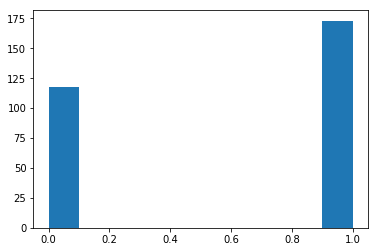

In [290]:
plt.hist(qy_cat)

In [291]:
uniform_length = DataUtils.get_max_len(X) + 5
word_map=DataUtils.load_wordmap_from_json('smiles_wordmap.json')
X_numeric = DataUtils.numeric_encoding(x_list=X, word_map=word_map, uniform_length=uniform_length)

In [325]:
X_train, X_test, y_train, y_test = DataUtils.splitData(x=X_numeric, y=qy_cat, ratio=0.2)
y_train = np.reshape(y_train, (-1, 1))
y_test = np.reshape(y_test, (-1, 1))
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(232, 279)
(59, 279)
(232, 1)
(59, 1)


In [326]:
#X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
#X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

rnn1_size = 224
rnn2_size = 384
dropout_rate = 0.2
loss = 'binary_crossentropy'

num_classes = 2
lr_metric = get_lr_metric(optimizer)
optimizer = Adam(lr=0.01) #use adam optimizer
metrics = ['accuracy', lr_metric]

#model_1 = Sequential()
#model_1.add(LSTM(rnn1_size, return_sequences=True, input_shape=(uniform_length,1))) 
#model_1.add(BatchNormalization())
#model_1.add(LSTM(rnn2_size))

#model_1.add(Dense(num_classes, activation='sigmoid'))

#model_1.summary()

embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(len(word_map), embedding_vecor_length, input_length=uniform_length))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))

model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', lr_metric])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 279, 32)           1344      
_________________________________________________________________
lstm_49 (LSTM)               (None, 100)               53200     
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 101       
Total params: 54,645
Trainable params: 54,645
Non-trainable params: 0
_________________________________________________________________
None


In [327]:
callbacks_list = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=1e-9, verbose=1, mode='auto',cooldown=0),
    ModelCheckpoint(filepath="qy.best_binary.hdf5", monitor='val_loss', save_best_only=True, verbose=1, mode='auto')    
]
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)


In [328]:
history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=250, validation_data=(X_test,y_test), callbacks=callbacks_list)

Train on 232 samples, validate on 59 samples
Epoch 1/250
232/232 [==============================] - 12s 52ms/step - loss: 0.7207 - acc: 0.5431 - lr: 0.0100 - val_loss: 0.6773 - val_acc: 0.7119 - val_lr: 0.0100

Epoch 00001: val_loss improved from inf to 0.67735, saving model to qy.best_binary.hdf5
Epoch 2/250
232/232 [==============================] - 2s 8ms/step - loss: 0.6890 - acc: 0.5647 - lr: 0.0100 - val_loss: 0.6327 - val_acc: 0.7119 - val_lr: 0.0100

Epoch 00002: val_loss improved from 0.67735 to 0.63273, saving model to qy.best_binary.hdf5
Epoch 3/250
232/232 [==============================] - 2s 8ms/step - loss: 0.6893 - acc: 0.5647 - lr: 0.0100 - val_loss: 0.6462 - val_acc: 0.7119 - val_lr: 0.0100

Epoch 00003: val_loss did not improve from 0.63273
Epoch 4/250
232/232 [==============================] - 2s 8ms/step - loss: 0.6847 - acc: 0.5647 - lr: 0.0100 - val_loss: 0.6718 - val_acc: 0.7119 - val_lr: 0.0100

Epoch 00004: val_loss did not improve from 0.63273
Epoch 5/250
232

232/232 [==============================] - 2s 8ms/step - loss: 0.6839 - acc: 0.5690 - lr: 0.0100 - val_loss: 0.6395 - val_acc: 0.7119 - val_lr: 0.0100

Epoch 00038: val_loss did not improve from 0.60095
Epoch 39/250
232/232 [==============================] - 2s 8ms/step - loss: 0.6865 - acc: 0.5690 - lr: 0.0100 - val_loss: 0.6546 - val_acc: 0.7119 - val_lr: 0.0100

Epoch 00039: val_loss did not improve from 0.60095
Epoch 40/250
232/232 [==============================] - 2s 8ms/step - loss: 0.6841 - acc: 0.5690 - lr: 0.0100 - val_loss: 0.6431 - val_acc: 0.7119 - val_lr: 0.0100

Epoch 00040: val_loss did not improve from 0.60095
Epoch 41/250
232/232 [==============================] - 2s 8ms/step - loss: 0.6842 - acc: 0.5690 - lr: 0.0100 - val_loss: 0.6390 - val_acc: 0.7119 - val_lr: 0.0100

Epoch 00041: val_loss did not improve from 0.60095
Epoch 42/250
232/232 [==============================] - 2s 8ms/step - loss: 0.6843 - acc: 0.5690 - lr: 0.0100 - val_loss: 0.6555 - val_acc: 0.7119 - 

232/232 [==============================] - 2s 8ms/step - loss: 0.6821 - acc: 0.5690 - lr: 0.0100 - val_loss: 0.6455 - val_acc: 0.7119 - val_lr: 0.0100

Epoch 00075: val_loss did not improve from 0.60095
Epoch 76/250
232/232 [==============================] - 2s 8ms/step - loss: 0.6826 - acc: 0.5690 - lr: 0.0100 - val_loss: 0.6423 - val_acc: 0.7119 - val_lr: 0.0100

Epoch 00076: val_loss did not improve from 0.60095
Epoch 77/250
232/232 [==============================] - 2s 9ms/step - loss: 0.6825 - acc: 0.5690 - lr: 0.0100 - val_loss: 0.6415 - val_acc: 0.7119 - val_lr: 0.0100

Epoch 00077: val_loss did not improve from 0.60095
Epoch 78/250
232/232 [==============================] - 2s 9ms/step - loss: 0.6830 - acc: 0.5690 - lr: 0.0100 - val_loss: 0.6443 - val_acc: 0.7119 - val_lr: 0.0100

Epoch 00078: val_loss did not improve from 0.60095
Epoch 79/250
232/232 [==============================] - 2s 9ms/step - loss: 0.6818 - acc: 0.5690 - lr: 0.0100 - val_loss: 0.6436 - val_acc: 0.7119 - 

232/232 [==============================] - 2s 10ms/step - loss: 0.6815 - acc: 0.5690 - lr: 0.0100 - val_loss: 0.6480 - val_acc: 0.7119 - val_lr: 0.0100

Epoch 00112: val_loss did not improve from 0.60095
Epoch 113/250
232/232 [==============================] - 2s 8ms/step - loss: 0.6813 - acc: 0.5690 - lr: 0.0100 - val_loss: 0.6473 - val_acc: 0.7119 - val_lr: 0.0100

Epoch 00113: val_loss did not improve from 0.60095
Epoch 114/250
232/232 [==============================] - 2s 8ms/step - loss: 0.6825 - acc: 0.5690 - lr: 0.0100 - val_loss: 0.6469 - val_acc: 0.7119 - val_lr: 0.0100

Epoch 00114: val_loss did not improve from 0.60095
Epoch 115/250
232/232 [==============================] - 2s 8ms/step - loss: 0.6813 - acc: 0.5690 - lr: 0.0100 - val_loss: 0.6470 - val_acc: 0.7119 - val_lr: 0.0100

Epoch 00115: val_loss did not improve from 0.60095
Epoch 116/250
232/232 [==============================] - 2s 9ms/step - loss: 0.6818 - acc: 0.5690 - lr: 0.0100 - val_loss: 0.6475 - val_acc: 0.71

232/232 [==============================] - 2s 9ms/step - loss: 0.6807 - acc: 0.5690 - lr: 0.0100 - val_loss: 0.6435 - val_acc: 0.7119 - val_lr: 0.0100

Epoch 00149: val_loss did not improve from 0.60095
Epoch 150/250
224/232 [===========================>..] - ETA: 0s - loss: 0.6836 - acc: 0.5580 - lr: 0.0100

KeyboardInterrupt: 

In [348]:

model = Sequential()
model.add(Embedding(input_dim = len(word_map), output_dim = 50, input_length = X_train.shape[1]))
model.add(BatchNormalization())
model.add(LSTM(output_dim=128,  return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(output_dim=128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))



print(model.summary())

C:\Users\Yang\.conda\envs\test_speedcom\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, units=128)`
  """
C:\Users\Yang\.conda\envs\test_speedcom\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=128)`
  import sys


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_32 (Embedding)     (None, 279, 50)           2100      
_________________________________________________________________
batch_normalization_32 (Batc (None, 279, 50)           200       
_________________________________________________________________
lstm_67 (LSTM)               (None, 279, 128)          91648     
_________________________________________________________________
dropout_61 (Dropout)         (None, 279, 128)          0         
_________________________________________________________________
lstm_68 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_62 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 129       
Total para

In [349]:
callbacks_list = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, min_lr=1e-9, verbose=1, mode='auto',cooldown=0),
    ModelCheckpoint(filepath="qy.best_binary.hdf5", monitor='val_loss', save_best_only=True, verbose=1, mode='auto')    
]

model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])


In [350]:
history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=100, validation_data=(X_test,y_test), callbacks=callbacks_list)

Train on 232 samples, validate on 59 samples
Epoch 1/100
232/232 [==============================] - 22s 96ms/step - loss: 0.6998 - acc: 0.5603 - val_loss: 0.7048 - val_acc: 0.2881

Epoch 00001: val_loss improved from inf to 0.70481, saving model to qy.best_binary.hdf5
Epoch 2/100
232/232 [==============================] - 11s 47ms/step - loss: 0.6918 - acc: 0.5259 - val_loss: 0.6348 - val_acc: 0.7119

Epoch 00002: val_loss improved from 0.70481 to 0.63482, saving model to qy.best_binary.hdf5
Epoch 3/100
232/232 [==============================] - 11s 46ms/step - loss: 0.6930 - acc: 0.5733 - val_loss: 0.6597 - val_acc: 0.7119

Epoch 00003: val_loss did not improve from 0.63482
Epoch 4/100
232/232 [==============================] - 11s 46ms/step - loss: 0.6842 - acc: 0.5474 - val_loss: 0.6063 - val_acc: 0.7119

Epoch 00004: val_loss improved from 0.63482 to 0.60632, saving model to qy.best_binary.hdf5
Epoch 5/100
232/232 [==============================] - 11s 46ms/step - loss: 0.6869 - ac

232/232 [==============================] - 12s 50ms/step - loss: 0.6841 - acc: 0.5690 - val_loss: 0.6651 - val_acc: 0.7119

Epoch 00043: val_loss did not improve from 0.60632
Epoch 44/100
232/232 [==============================] - 12s 50ms/step - loss: 0.6861 - acc: 0.5690 - val_loss: 0.6698 - val_acc: 0.7119

Epoch 00044: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00044: val_loss did not improve from 0.60632
Epoch 45/100
232/232 [==============================] - 12s 51ms/step - loss: 0.6835 - acc: 0.5690 - val_loss: 0.6661 - val_acc: 0.7119

Epoch 00045: val_loss did not improve from 0.60632
Epoch 46/100
232/232 [==============================] - 12s 50ms/step - loss: 0.6831 - acc: 0.5690 - val_loss: 0.6591 - val_acc: 0.7119

Epoch 00046: val_loss did not improve from 0.60632
Epoch 47/100
232/232 [==============================] - 12s 50ms/step - loss: 0.6843 - acc: 0.5690 - val_loss: 0.6526 - val_acc: 0.7119

Epoch 00047: val_loss did not improve from 

KeyboardInterrupt: 